In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, metrics, utils
# from tensorflow.keras.utils.np_utils import probas_to_classes
dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftest_raw.head(10)
# dftrain_raw.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,0,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,1,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,0,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,0,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


Text(0.5, 0, 'Survived')

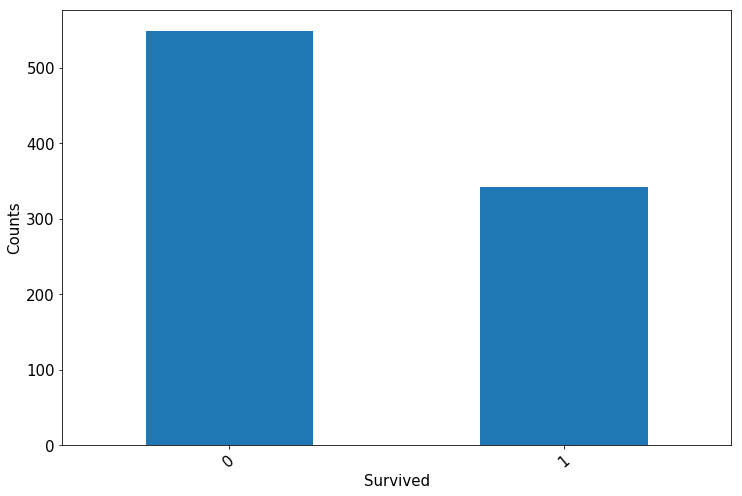

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='png'
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar',
                                                 figsize=(12,8),fontsize=15,rot=40)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)


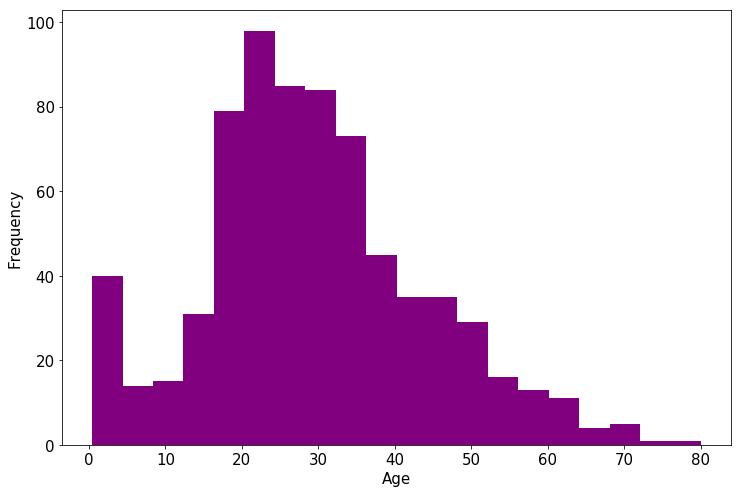

In [6]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind='hist', bins=20, color='purple', figsize=(12,8), fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()

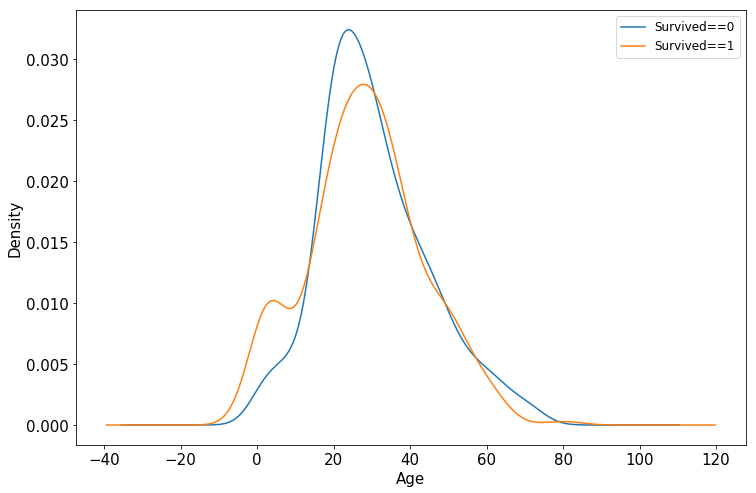

In [7]:
# Age与label(survived)的相关性
ax = dftrain_raw.query('Survived==0')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
dftrain_raw.query('Survived==1')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
ax.legend(['Survived==0', 'Survived==1'], fontsize=12)
ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()    

In [14]:
def preprocessing(dfdata):
    # 创建一个空的DataFrame，后面和新生成的daaframe进行concat！！！
    dfresult = pd.DataFrame()

    # Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass'+str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult, dfPclass], axis=1)

    # Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis=1)

    # Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isnull(dfdata['Age']).astype('int32')
    print('dfresult:\n', dfresult.head(10))

    # SibSp, Parch, Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    # Carbin
    # Carbin这个段不需要dummies么？？？
    dfresult['Cabin_null'] = pd.isnull(dfdata['Cabin']).astype('int32')

    # Embarked
    # 这种把空值一同放在dummies列和为了空值单独生成一列有什么区别？？？
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)
    
    return dfresult

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values
print('x_train.shape = ', x_train.shape)
print('x_test.shape = ', x_test.shape)

dfresult:
    Pclass1  Pclass2  Pclass3  female  male   Age  Age_null
0        0        0        1       0     1  22.0         0
1        1        0        0       1     0  38.0         0
2        0        0        1       1     0  26.0         0
3        1        0        0       1     0  35.0         0
4        0        0        1       0     1  35.0         0
5        0        0        1       0     1   0.0         1
6        1        0        0       0     1  54.0         0
7        0        0        1       0     1   2.0         0
8        0        0        1       1     0  27.0         0
9        0        1        0       1     0  14.0         0
dfresult:
    Pclass1  Pclass2  Pclass3  female  male   Age  Age_null
0        0        0        1       0     1  34.5         0
1        0        0        1       1     0  47.0         0
2        0        1        0       0     1  62.0         0
3        0        0        1       0     1  27.0         0
4        0        0        1      

Keras接口有以下3种方式构建模型：
1. 使用Sequential按层顺序构建模型
2. 使用函数式API构建任意结构模型
3. 继承Model基类构建自定义模型

In [9]:
#此处选择使用最简单的Sequential，按层顺序模型
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(15,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


##训练模型
训练模型通常有3中方法：
1. 内置fit方法
2. 内置train_on_batch方法
3. 自定义训练循环

In [10]:
# 二分类问题选择二元交叉熵损失函数
# metircs选择这块有问题？？？
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# （1）iteration：表示1次迭代（也叫training step），每次迭代更新1次网络结构的参数；

# （2）batch-size：1次迭代所使用的样本量；

# （3）epoch：1个epoch表示过了1遍训练集中的所有样本。
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2)


Train on 712 samples, validate on 179 samples
Epoch 1/30
712/712 [==============================] - 0s 243us/sample - loss: 1.6771 - acc: 0.4213 - val_loss: 1.3878 - val_acc: 0.5642
Epoch 2/30
712/712 [==============================] - 0s 24us/sample - loss: 1.2118 - acc: 0.5941 - val_loss: 1.0265 - val_acc: 0.6648
Epoch 3/30
712/712 [==============================] - 0s 25us/sample - loss: 0.8625 - acc: 0.6362 - val_loss: 0.7146 - val_acc: 0.7039
Epoch 4/30
712/712 [==============================] - 0s 24us/sample - loss: 0.6939 - acc: 0.6629 - val_loss: 0.5699 - val_acc: 0.7263
Epoch 5/30
712/712 [==============================] - 0s 24us/sample - loss: 0.6515 - acc: 0.6924 - val_loss: 0.5435 - val_acc: 0.7430
Epoch 6/30
712/712 [==============================] - 0s 24us/sample - loss: 0.6284 - acc: 0.6798 - val_loss: 0.5402 - val_acc: 0.7486
Epoch 7/30
712/712 [==============================] - 0s 22us/sample - loss: 0.6097 - acc: 0.6685 - val_loss: 0.5524 - val_acc: 0.7263
Epoch 8/

评估模型

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

def plot_metric(history, metirc):
    train_metrics = history.history[metirc]
    val_metrics = history.history['val_'+metirc]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+metirc)
    plt.xlabel('Epochs')
    plt.legend(['train_'+metirc, 'val_'+metirc])
    plt.show()

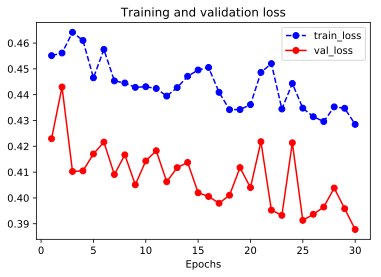

In [53]:
plot_metric(history, 'loss')

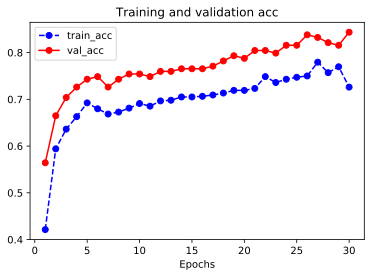

In [12]:
plot_metric(history, 'acc')

# 模型在测试集上的效果

In [15]:
# 目前y_test没有值，还不能评估在测试集上的效果
model.evaluate(x = x_test, y = y_test)

418/418 [==============================] - 0s 19us/sample - loss: nan - acc: 0.7967


[nan, 0.7966507]

# 使用模型

In [21]:

#预测概率
y_prob = model.predict(x_test[0:10])
#等价写法，有了数据后测试一下这种写法
#model(tf.constant(x_test[0:10].values, dtype=tf.float32))
#预测类别  cannot import name 'probas_to_classes'??? squential model 没有predict_class函数么???
# model.predict_class(x_test[0:10])
y_classes = y_prob.argmax(axis=-1)
print('y_prob:\n', y_prob)
print('y_classes:\n', y_classes)

y_prob:
 [[0.20072186]
 [0.27273944]
 [0.18305618]
 [0.21682063]
 [0.4269126 ]
 [0.27488184]
 [0.3999251 ]
 [0.38533252]
 [0.5087865 ]
 [0.2877342 ]]
y_classes:
 [0 0 0 0 0 0 0 0 0 0]


# 保存模型
1. 可以使用Keras方式保存模型，仅适合使用Python环境恢复模型
2. 也可以使用TensorFlow原生方式保存，可以跨平台进行模型部署

In [55]:
# 1. Keras方式保存
#保存模型结构及权重
model.save('./data/structured_data_model.h5')
del model

# identical to the previous one
model = models.load_model('./data/structured_data_model.h5')
# model.evaluate(x_test, y_test)

In [58]:
# 保存模型结构
json_str = model.to_json()
# 恢复模型结构
model_json = models.model_from_json(json_str)
# 保存模型权重
model.save_weights('./data/structured_data_model_weight.h5')
# 恢复模型结构
model_json = models.model_from_json(json_str)
# metrics取值为什么不能是'AUC'???
model_json.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# 加载权重
model_json.load_weights('./data/structured_data_model_weight.h5')
# model_json.evaluate(x_test, y_test)

In [63]:
# 2. TensorFlow原生方式保存
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/structured_data_model_weights.ckpt', save_format='tf')
# 保存模型结构与模型参数到文件，该方式保存的模型具有跨平台性便于部署
# model.save没有save_format参数么？？？
model.save('./data/structured_data_model', save_format='tf')
print('export save model.')

model_loaded = tf.keras.models.load_model('./data/structured_data_model')
# model_loaded.evaluate(x_test, y_test)


Consider using a TensorFlow optimizer from `tf.train`.


TypeError: save() got an unexpected keyword argument 'save_format'